In [4]:
import os
import pandas as pd
import numpy as np
import sys
import sklearn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

2023-05-27 14:21:01.232261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [17]:
filename = '/home/ekramul/Downloads/DroneRF/CombinedDroneDATA'

In [18]:
#Droned_Database_details
# Path of raw RF data
BUI = ['00000','10000','10001','10010','10011','10100','10101','10110','10111','11000']
N_seg = int(1e7)

# Counting
c = [0] * len(BUI)
for i in range(len(BUI)):
  c[i] = len([name for name in os.listdir(filename) if name.startswith(BUI[i])])

# Level 1 details
L1 = [0] * 2
L1[0] = N_seg * sum(c[1:])
L1[1] = N_seg * c[0]
P1 = [100 * L1[i] / sum(L1) for i in range(len(L1))]

# Level 2 details
L2 = [0] * 4
L2[0] = N_seg * sum(c[1:5])
L2[1] = N_seg * sum(c[5:9])
L2[2] = N_seg * c[9]
L2[3] = N_seg * c[0]
P2 = [100 * L2[i] / sum(L2) for i in range(len(L2))]

# Level 3 details
L3 = [0] * 10
L3[0] = N_seg * c[1]
L3[1] = N_seg * c[2]
L3[2] = N_seg * c[3]
L3[3] = N_seg * c[4]
L3[4] = N_seg * c[5]
L3[5] = N_seg * c[6]
L3[6] = N_seg * c[7]
L3[7] = N_seg * c[8]

FileNotFoundError: [Errno 2] No such file or directory: '/home/ekramul/Downloads/DroneRF/CombinedDroneDATA'

In [ ]:
#DroneSnippets


# Path of raw RF data
csvfiles = [file for file in os.listdir(filename) if file.endswith('.csv')]

# Parameters
BUI = [['00000'],
       ['10000','10001','10010','10011'], 
       ['10100','10101','10110','10111'],
       ['11000']]
fs = 40e6
opt = np.array([[1, 1, 5],
                [2, 4, 10],
                [4, 1, 7]])

# Main
for i in range(3):
    # Loading
    x = np.loadtxt(os.path.join(filename, BUI[opt[i,0]-1][0] + 'L_' + str(opt[i,2]) + '.csv'), delimiter=',')
    y = np.loadtxt(os.path.join(filename, BUI[opt[i,0]-1][0] + 'H_' + str(opt[i,2]) + '.csv'), delimiter=',')
    x = x / np.max(np.abs(x))
    y = y / np.max(np.abs(y))
    t = np.arange(0, len(x)/fs, 1/fs)
    # Plotting
    fig, ax = plt.subplots(figsize=(8.4, 6))
    ax.plot(t, x, label=r'$x^{(L)}$')
    ax.plot(t, y-2, 'r', label=r'$x^{(H)}$')
    ax.set_ylim(-3.1, 1.1)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Signal amplitude', fontsize = 12)
    ax.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), fontsize=16)
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=16)
    # Saving
    fig.savefig('/home/ekramul/Downloads/DroneRF/Output/Snippets/snippet_{}.pdf'.format(i), dpi=512, bbox_inches='tight')

# End of program
print('All snippets are saved as PDF files.')

In [ ]:
load_filename = '/home/ekramul/Downloads/DroneRF/Output' # Path of raw RF data
save_filename = load_filename

# Parameters
BUI = [
    ['00000'], # BUI of RF background activities
    ['10000','10001','10010','10011'], # BUI of the Bebop drone RF activities
    ['10100','10101','10110','10111'], # BUI of the AR drone RF activities
    ['11000'] # BUI of the Phantom drone RF activities
]

# Loading and concatenating RF data
T = len(BUI)
DATA = np.array([])
LN = []
for t in range(T):
    for b in range(len(BUI[t])):
        Data = np.load(os.path.join(load_filename, BUI[t][b] + '.npy'))
        Data = Data / np.max(Data)
        if DATA.size == 0:
            DATA = Data
        else:
            DATA = np.concatenate((DATA, Data), axis=1)
        LN.append(Data.shape[1])

# Labeling
zeros = np.zeros((3, sum(LN)))
Label = np.zeros((3, sum(LN)))
Label[0, :LN[0]] = np.zeros(LN[0])
Label[0, LN[0]:sum(LN[1:5])] = np.ones(sum(LN[1:5]) - LN[0])
Label[1, :LN[0]] = np.zeros(LN[0])
Label[1, LN[0]:sum(LN[1:5])] = np.ones(sum(LN[1:5]) - LN[0])
temp = np.array([])

for i in range(5):
    temp = np.concatenate((temp, np.arange(1, LN[i]+1)))
    Label[2, sum(LN[:i]):sum(LN[:i+1])] = i

# Saving
np.savetxt(os.path.join(save_filename, 'RF_Data.csv'), np.concatenate((DATA, Label), axis=0), delimiter=',')

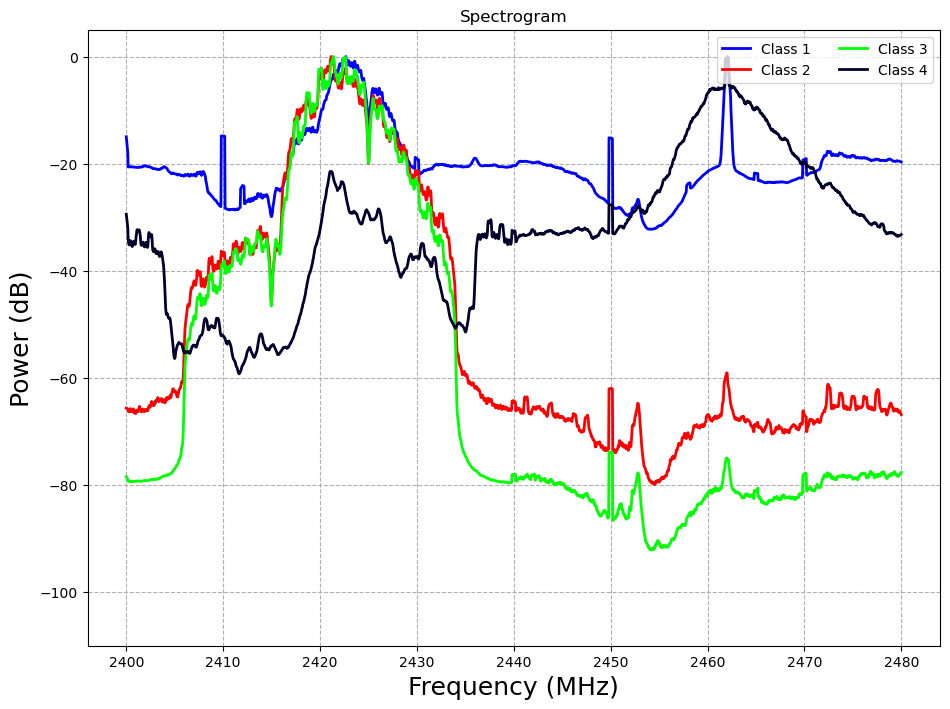

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

filepath = os.path.join(os.path.dirname(os.getcwd()), "/home/ekramul/Downloads/DroneRF/AggregatedData")

# Parameters
opt = 2  # Change to 1, 2, or 3 to alternate between the 1st, 2nd, and 3rd DNN inputs respectively.
BUI = ['00000', '10000', '10001', '10010', '10011',
       '10100', '10101', '10110', '10111', '11000']  # BUI of all RF data
M = 2048  # Total number of frequency bins
fs = 80  # Sampling frequency in MHz
f = np.linspace(2400, 2400 + fs, M)  # Frequency array for plotting
S = 10  # Number of points in the moving average filter for smoothing
c = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 0.1724],
              [1, 0.1034, 0.7241], [1, 0.8276, 0], [0, 0.3448, 0],
              [0.5172, 0.5172, 1], [0.6207, 0.3103, 0.2759],
              [0, 1, 0.7586]])  # 10 distinct colours for plotting

# Averaging spectra
s = np.zeros((len(BUI), M))
for i in range(len(BUI)):
    x = np.load(os.path.join(filepath, f"{BUI[i]}.npy"))
    s[i, :] = np.mean(x, axis=1)

# Aggregating and smoothing RF spectra
if opt == 1:
    sig = np.zeros((2, M))
    sig[0, :] = s[0, :]
    sig[1, :] = np.mean(s[1:, :], axis=0)
    sig_smooth = savgol_filter(sig, S, 1)
elif opt == 2:
    sig = np.zeros((4, M))
    sig[0, :] = s[0, :]
    sig[1, :] = np.mean(s[1:5, :], axis=0)
    sig[2, :] = np.mean(s[5:9, :], axis=0)
    sig[3, :] = s[9, :]
    sig_smooth = savgol_filter(sig, S, 1)
elif opt == 3:
    sig = s
    sig_smooth = savgol_filter(sig, S, 1)

# Plotting
fig, ax = plt.subplots(figsize=(11, 8))
a = []

for i in range(sig.shape[0]):
    line, = ax.plot(f, 20 * np.log10(sig_smooth[i, :] / np.max(sig_smooth[i, :])), color=c[i], linewidth=2)
    a.append(line)
    tt = [f"Class {i+1}" for i in range(sig.shape[0])]

ax.set_xlabel("Frequency (MHz)", fontsize=18)
ax.set_ylabel("Power (dB)", fontsize=18)
ax.set_ylim([-110, 5])
ax.legend(a, tt, loc="upper right", ncol=2)
ax.grid(True, which="both", linestyle="--")
ax.set_title("Spectrogram")
plt.show()

In [9]:
import numpy as np
import os

load_filename = '/home/ekramul/Downloads/DroneRF/AggregatedData'  # Path of raw RF data
save_filename = load_filename

# Parameters
BUI = [
    ['00000'],  # BUI of RF background activities
    ['10000', '10001', '10010', '10011'],  # BUI of the Bebop drone RF activities
    ['10100', '10101', '10110', '10111'],  # BUI of the AR drone RF activities
    ['11000'],  # BUI of the Phantom drone RF activities
]

# Loading and concatenating RF data
T = len(BUI)
DATA = np.array([])
LN = []

for t in range(T):
    for b in range(len(BUI[t])):
        Data = np.load(os.path.join(load_filename, BUI[t][b] + '.npy'))
        Data = Data / np.max(Data)
        DATA = np.hstack((DATA, Data)) if DATA.size else Data
        LN.append(Data.shape[1])
        del Data
    print(100 * (t + 1) / T)

# Labeling
Label = np.zeros((3, np.sum(LN)))
Label[0, LN[0]:] = 1
Label[1, LN[0]:LN[0] + np.sum(LN[1:5])] = 1
Label[1, LN[0] + np.sum(LN[1:5]):LN[0] + np.sum(LN[1:9])] = 2
Label[1, LN[0] + np.sum(LN[1:9]):] = 3
temp = []

for i in range(len(LN)):
    temp.extend([(i - 1)] * LN[i])

Label[2] = temp

# Saving
np.savetxt(os.path.join(save_filename, 'RF_Data.csv'), np.vstack((DATA, Label)), delimiter=',')


25.0
50.0
75.0
100.0


In [12]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [13]:
param_distribs = {"n_hidden" : [0,1,2,3,4], "n_neurons" : np.arange(1,100),}

In [14]:
rnd_search_cv = RandomizedSearchCV(keras_reg,param_distribs,n_iter =10, cv=3),


NameError: name 'keras_reg' is not defined

In [22]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


############################### Loading ##################################
print("Loading Data ...")
Data = np.loadtxt("/home/ekramul/Downloads/DroneRF/AggregatedData/RF_Data.csv", delimiter=",")
############################## Splitting #################################
print("Preparing Data ...")
x = np.transpose(Data[0:2047,:])
print(x.shape)
# ...

############################## Standardizing ################################
print("Standardizing Data ...")
sc = StandardScaler()
x = sc.fit_transform(x)

############################## Apply PCA ################################
print("Applying PCA ...")
pca = PCA(n_components= 0.95)# adjust based on your requirements
x = pca.fit_transform(x)

Loading Data ...
Preparing Data ...
(22700, 2047)
Standardizing Data ...
Applying PCA ...


In [23]:
x.shape

(22700, 688)

In [24]:
#4 Class

import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

############################## Functions ###############################
def decode(datum):
    y = np.zeros((datum.shape[0],1))
    for i in range(datum.shape[0]):
        y[i] = np.argmax(datum[i])
    return y
def encode(datum):
    return to_categorical(datum)
############################# Parameters ###############################
np.random.seed(1)
K                    = 10
inner_activation_fun = 'relu'
outer_activation_fun = 'sigmoid'
optimizer_loss_fun   = 'mse'
optimizer_algorithm  = 'adam'
number_inner_layers  = 3
number_inner_neurons = 256
number_epoch         = 200
batch_length         = 10
show_inter_results   = 0
############################### Loading ##################################
Label_1 = np.transpose(Data[2048:2049,:]); Label_1 = Label_1.astype(int); print("Label_1.shape:%",Label_1.shape)
Label_2 = np.transpose(Data[2049:2050,:]); Label_2 = Label_2.astype(int); print(Label_2.shape)
Label_3 = np.transpose(Data[2050:2051,:]); Label_3 = Label_3.astype(int); print(Label_3.shape)
y = encode(Label_2)
print(y.shape)

################################ Main ####################################
cvscores    = []
cnt         = 0
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
for train, test in kfold.split(x, decode(y)):
    cnt = cnt + 1
    print(cnt)
    model = Sequential()
    for i in range(number_inner_layers):
        model.add(Dense(int(number_inner_neurons/2), input_dim = x.shape[1], activation = inner_activation_fun))
    model.add(Dense(y.shape[1], activation = outer_activation_fun))
    model.compile(loss = optimizer_loss_fun, optimizer = optimizer_algorithm, metrics =         ['accuracy'])
    model.fit(x[train], y[train], epochs = number_epoch, batch_size = batch_length, verbose = show_inter_results)
    scores = model.evaluate(x[test], y[test], verbose = show_inter_results)
    print(scores[1]*100)
    cvscores.append(scores[1]*100)
    y_pred = model.predict(x[test])
    np.savetxt("Results_2%s.csv" % cnt, np.column_stack((y[test], y_pred)), delimiter=" ,", fmt='%s')

Label_1.shape:% (22700, 1)
(22700, 1)
(22700, 1)
(22700, 4)
1
83.83259773254395
2
85.55065989494324
3
84.00881290435791
4
83.78854393959045
5
82.99559354782104
6
83.87665152549744
7
83.92070531845093
8
83.03964734077454
9
84.53744649887085
10
85.24228930473328


In [25]:
model.save('model.h5')


In [3]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')


2023-05-24 10:45:23.529758: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-24 10:45:23.533153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-24 10:45:23.600948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:45:23.601074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.725GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-05-24 10:45:23.601087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-24 10:45:23.618189: I tensorflow/stream_executor/platform/de

In [26]:
# Class names
class_names = ['No Drone','Bebop Drone','AR Drone','Phantom Drone']

# Training data
x_train = x[train]
y_train = decode(y[train])

# Test data
x_test = x[test]
y_test = decode(y[test])

# Get an example from each class in the training set
images_dict = dict()
for i, label in enumerate(y_train):
    label = int(label)
    if len(images_dict) == len(class_names):
        break
    if label not in images_dict.keys():
        images_dict[label] = x_train[i]

# Get an example from each class in the test set
x_test_dict = dict()
for i, label in enumerate(y_test):
    label = int(label)
    if len(x_test_dict) == len(class_names):
        break
    if label not in x_test_dict.keys():
        x_test_dict[label] = x_test[i]

# Array with one example from each class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Make predictions using your trained model
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

# Print Predicted Class
for i, pc in enumerate(predicted_class):
    print(f'Test example {i}: True Class = {class_names[i]}, Predicted Class = {class_names[pc]}')



Test example 0: True Class = No Drone, Predicted Class = No Drone
Test example 1: True Class = Bebop Drone, Predicted Class = Bebop Drone
Test example 2: True Class = AR Drone, Predicted Class = AR Drone
Test example 3: True Class = Phantom Drone, Predicted Class = Bebop Drone


In [27]:
x.shape

(22700, 688)

In [28]:
x[train].shape

(20430, 688)

  0%|          | 0/14 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


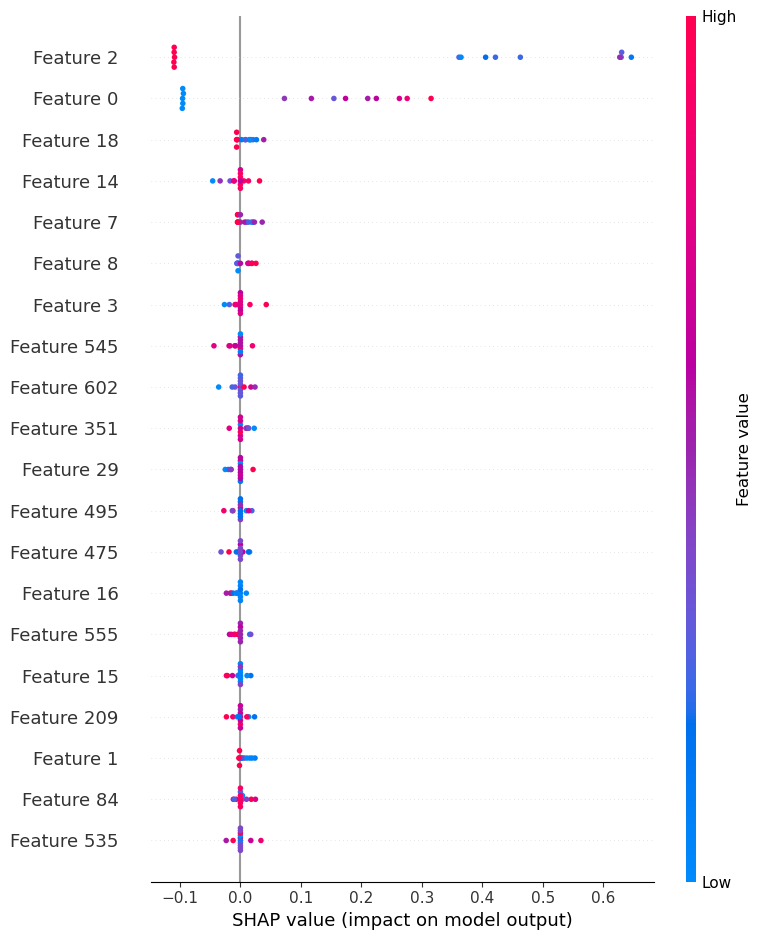

In [29]:

import shap

# Get the predictions and put them with the test data
x_output = x[test].copy()
predictions = np.round(model.predict(x_output), 2)
x_output = np.column_stack((x_output, predictions))

# Randomly pick some observations
random_picks = np.arange(1, 688,50) # Every 50 rows
S = x_output[random_picks]
S = S[:, :688]  # Select the first 688 features

background = x[train[np.random.choice(len(train), 100, replace=False)]]
background_array = np.array(background)
# Compute the SHAP values
explainerModel = shap.KernelExplainer(model, background_array)
shap_values_Model = explainerModel.shap_values(S)

# Plot the SHAP values
shap.summary_plot(shap_values_Model[0], S)


In [30]:
print(shap_values_Model[0])

[[ 0.17388713  0.02415254  0.46298513 ... -0.00726006  0.
  -0.01039231]
 [ 0.31533569  0.00649445  0.36490072 ... -0.01471659 -0.0080989
   0.        ]
 [ 0.07282777  0.01924268  0.62972449 ... -0.00176957  0.01246603
  -0.00758475]
 ...
 [-0.0961388  -0.00137465 -0.10896609 ...  0.          0.
   0.        ]
 [-0.09536616 -0.00149566 -0.10959333 ...  0.          0.
   0.        ]
 [-0.0943183  -0.00110574 -0.10952063 ...  0.          0.
   0.        ]]


In [24]:
shap_values_Model[0].shape

(14, 688)

In [35]:
# First, we'll find the indices of the instances that belong to each class.
indices_by_class = {class_: np.where(y == class_)[0] for class_ in np.unique(y)}

# Now we can select an instance from each class.
selected_indices = [indices[np.random.choice(len(indices))] for indices in indices_by_class.values()]

# Here are the selected instances.
selected_instances = x[selected_indices]


In [37]:
import lime
from lime import lime_tabular

# Create feature names
feature_names = ['Feature ' + str(i) for i in range(x[train].shape[1])]

# Create a Lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data=x[train],
                                               mode='classification',
                                               feature_names=feature_names,
                                               class_names=list(range(y.shape[1])),
                                               discretize_continuous=True)

# assuming 'x' is a 2d array where each row is a data instance
for idx in selected_indices:
    instance = x[idx]
    # Reshape the instance to have shape (1, number_of_features).
    instance = instance.reshape(1, -1)
    exp = explainer.explain_instance(instance[0], model.predict_proba, num_features=5)
    print('Instance: %d' % idx)
    print('Probability(churn) =', model.predict_proba(instance))
    print('True class: %s' % y[idx])
    exp.show_in_notebook(show_all=False)


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.

                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


Instance: 16929
Probability(churn) = [[0.0000000e+00 2.9504584e-19 1.0000000e+00 1.4168963e-15]]
True class: [0. 0. 1. 0.]


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.

                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


Instance: 5768
Probability(churn) = [[6.6683002e-05 7.2764242e-01 1.9329034e-01 8.6596683e-02]]
True class: [0. 1. 0. 0.]


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


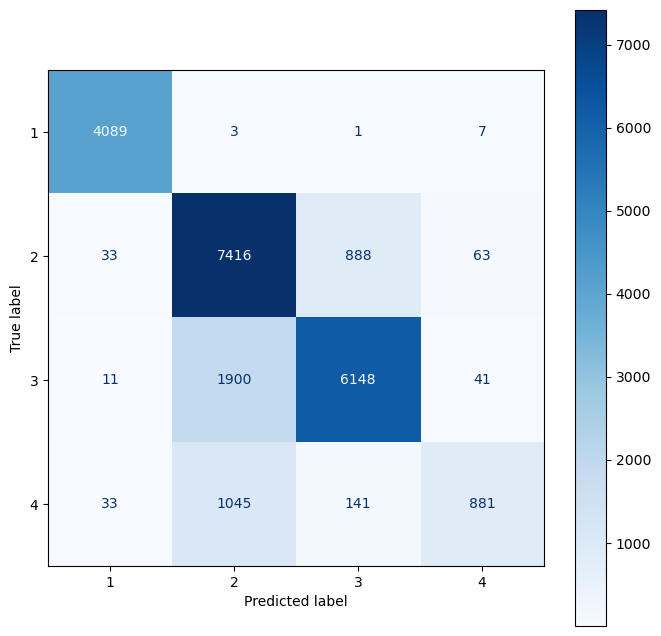

Do you want to save the results (Y/N)
N


In [11]:
#Confusion Matrix

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

filepath = os.path.join(os.path.dirname(os.getcwd()), "/home/ekramul/DroneDetection")

# Parameters
opt = 2  # Change to 1, 2, or 3 to alternate between the 1st, 2nd, and 3rd DNN results respectively.

# Main
y = []

for i in range(1, 11):
    x = np.genfromtxt(os.path.join(filepath, f"Results_{opt}{i}.csv"), delimiter=',')
    y.append(x)

y = np.vstack(y)

# Plotting confusion matrix
if opt == 1:
    cm = confusion_matrix(y[:, 0], y[:, 1])
    display_labels = [1, 2]
elif opt == 2:
    cm = confusion_matrix(y[:, 0:4].argmax(axis=1), y[:, 4:8].argmax(axis=1))
    display_labels = [1, 2, 3, 4]
elif opt == 3:
    cm = confusion_matrix(y[:, 0:10].argmax(axis=1), y[:, 10:20].argmax(axis=1))
    display_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(ax=ax, cmap=plt.cm.Blues, values_format="d")
plt.show()

# Saving
Q = input("Do you want to save the results (Y/N)\n")

if Q.lower() == "y":
    fig.savefig(f"confusion_matrix_{opt}.pdf", dpi=512)


In [ ]:
Y
